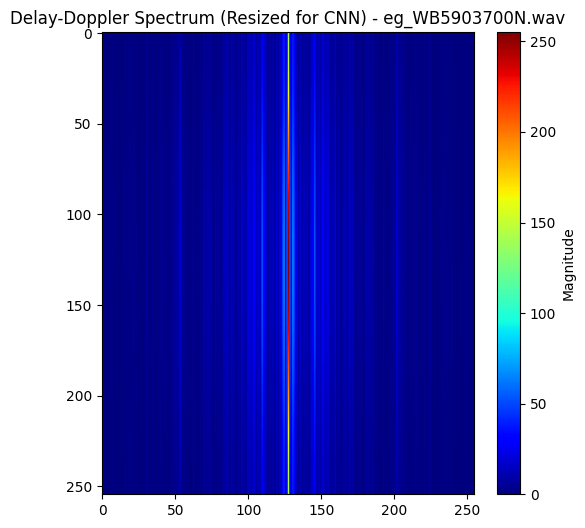

Playing audio for Sample eg_WB5903700N.wav


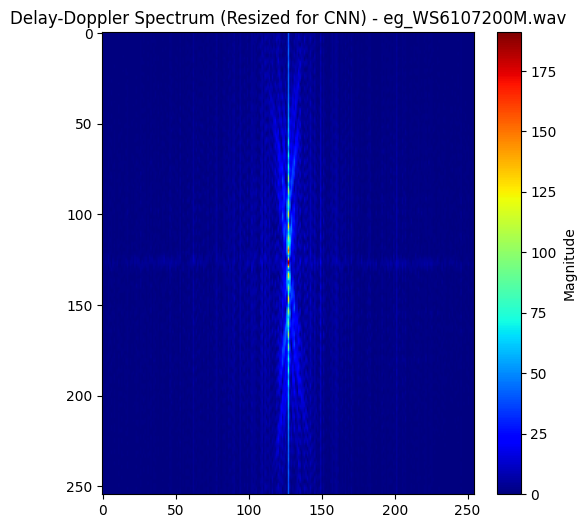

Playing audio for Sample eg_WS6107200M.wav


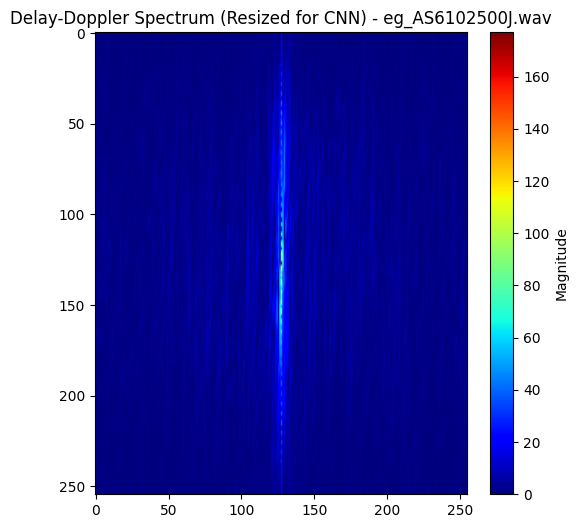

Playing audio for Sample eg_AS6102500J.wav


In [5]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import os
import cv2  # 用于调整图像尺寸
from scipy.signal import stft
from IPython.display import Audio

# 文件路径
file_paths = [
    r"D:\Dataset\Marine-Mammal-Target-Classification\02_Features\eg_WB5903700N.wav",
    r"D:\Dataset\Marine-Mammal-Target-Classification\02_Features\eg_WS6107200M.wav",
    r"D:\Dataset\Marine-Mammal-Target-Classification\02_Features\eg_AS6102500J.wav"
]

# CNN 目标输入尺寸
target_size = (255, 255)  # 适配 CNN

# 计算模糊函数（Delay-Doppler 变换）
def ambiguity_function(signal, sample_rate, win_len=256, hop_size=128):
    f, t, Zxx = stft(signal, fs=sample_rate, nperseg=win_len, noverlap=hop_size)
    AF = np.abs(np.fft.fftshift(np.fft.ifft2(np.abs(Zxx) ** 2)))
    return AF

# 遍历所有文件并绘制 Delay-Doppler 变换图
for file_path in file_paths:
    # 读取 WAV 文件
    sample_rate, data = wav.read(file_path)

    # 如果是双声道音频，取一个通道
    if len(data.shape) > 1:
        data = data[:, 0]

    # 归一化到 [-1, 1]
    data = data.astype(np.float32)
    data = data / np.max(np.abs(data))

    # 计算 Delay-Doppler 变换（模糊函数）
    dd_spectrum = ambiguity_function(data, sample_rate)

    # 归一化到 [0, 255]
    dd_spectrum = (dd_spectrum - np.min(dd_spectrum)) / (np.max(dd_spectrum) - np.min(dd_spectrum))  # 归一化到 [0,1]
    dd_image = (dd_spectrum * 255).astype(np.uint8)  # 转换为 uint8 格式

    # 调整分辨率以适应 CNN
    dd_resized = cv2.resize(dd_image, target_size, interpolation=cv2.INTER_CUBIC)

    # 绘制调整后的 Delay-Doppler 变换图
    plt.figure(figsize=(6, 6))
    plt.imshow(dd_resized, aspect='auto', cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.title(f"Delay-Doppler Spectrum (Resized for CNN) - {os.path.basename(file_path)}")
    plt.show()

    # 播放音频
    print(f"Playing audio for Sample {os.path.basename(file_path)}")
    display(Audio(data, rate=sample_rate))


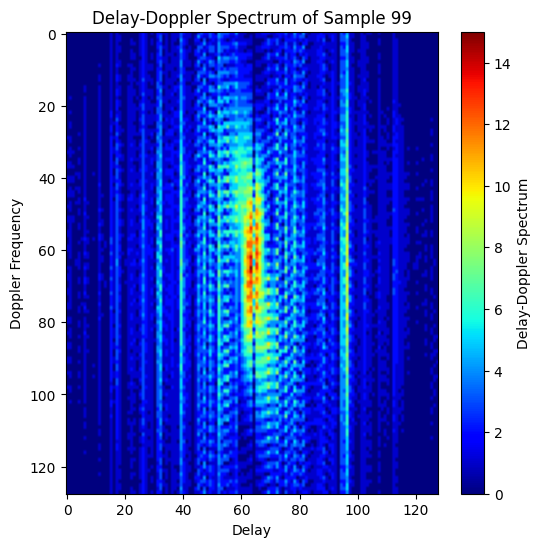

Playing audio for Sample 61072031_seg19 (Sampling Rate: 60600 Hz)


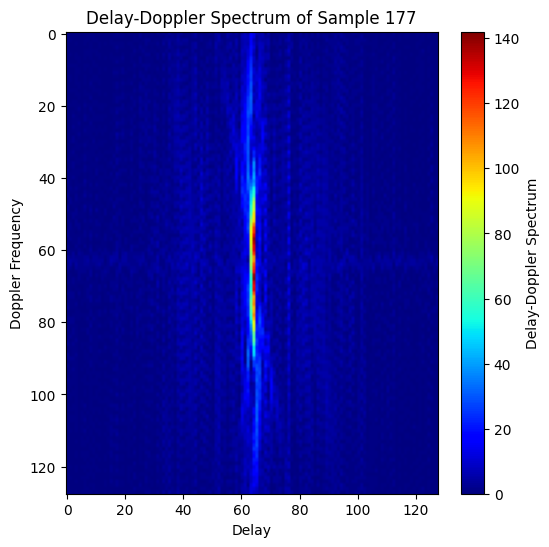

Playing audio for Sample 6107202K_seg4 (Sampling Rate: 80000 Hz)


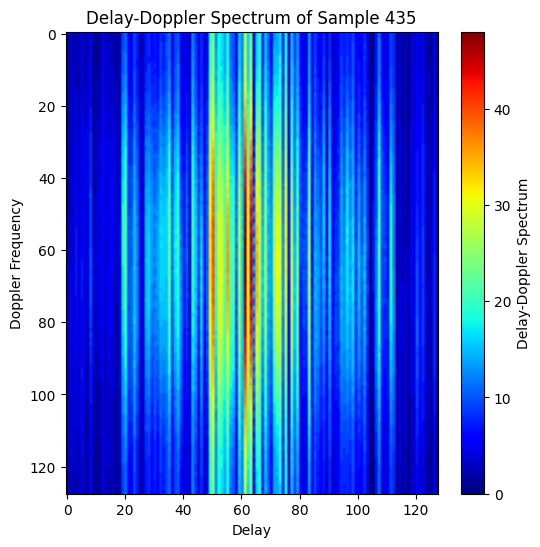

Playing audio for Sample 59037007_seg9 (Sampling Rate: 60600 Hz)


In [9]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import cv2  # 用于调整图像尺寸
import random
from IPython.display import Audio

# 读取数据
X_train = np.load(r"D:\Dataset\Temp_Results\Train_Test\X_train.npy")
X_test = np.load(r"D:\Dataset\Temp_Results\Train_Test\X_test.npy")
Y_train = np.load(r"D:\Dataset\Temp_Results\Train_Test\y_train.npy")
Y_test = np.load(r"D:\Dataset\Temp_Results\Train_Test\y_test.npy")
ids_train = np.load(r"D:\Dataset\Temp_Results\Train_Test\ids_train.npy")
ids_test = np.load(r"D:\Dataset\Temp_Results\Train_Test\ids_test.npy")
sr_train = np.load(r"D:\Dataset\Temp_Results\Train_Test\sr_train.npy")  # 训练集采样率
sr_test = np.load(r"D:\Dataset\Temp_Results\Train_Test\sr_test.npy")  # 测试集采样率

# 选取3个随机样本
random_indices = random.sample(range(X_train.shape[0]), 3)
selected_signals = X_train[random_indices, :]
selected_ids = ids_train[random_indices]
selected_srs = sr_train[random_indices]  # 获取对应的采样率

# 计算模糊函数（Delay-Doppler 变换）
def ambiguity_function(input_signal, sample_rate, win_len=256, hop_size=128):
    f, t, Zxx = sig.stft(input_signal, fs=sample_rate, nperseg=win_len, noverlap=hop_size)
    AF = np.abs(np.fft.fftshift(np.fft.ifft2(np.abs(Zxx) ** 2)))
    return AF

# 遍历所选样本并计算 Delay-Doppler 变换
for i, (sig_sample, sample_rate) in enumerate(zip(selected_signals, selected_srs)):
    # 归一化到 [-1, 1]
    sig_sample = sig_sample.astype(np.float32)
    sig_sample = sig_sample / np.max(np.abs(sig_sample))

    # 计算 Delay-Doppler 变换（模糊函数）
    dd_spectrum = ambiguity_function(sig_sample, sample_rate)

    # 归一化到 [0,255]（增强稳定性）
    if np.max(dd_spectrum) - np.min(dd_spectrum) > 0:
        dd_spectrum = (dd_spectrum - np.min(dd_spectrum)) / (np.max(dd_spectrum) - np.min(dd_spectrum))
    else:
        dd_spectrum = np.zeros_like(dd_spectrum)  # 防止除零错误
    
    dd_resized = cv2.resize((dd_spectrum * 255).astype(np.uint8), (128, 128), interpolation=cv2.INTER_CUBIC)

    # 绘图
    plt.figure(figsize=(6, 6))
    plt.imshow(dd_resized, aspect='auto', cmap='jet')
    plt.colorbar(label='Delay-Doppler Spectrum')
    plt.ylabel("Doppler Frequency")
    plt.xlabel("Delay")
    plt.title(f"Delay-Doppler Spectrum of Sample {random_indices[i]}")
    plt.show()

    # 播放音频（使用正确的采样率）
    print(f"Playing audio for Sample {selected_ids[i]} (Sampling Rate: {sample_rate} Hz)")
    display(Audio(sig_sample, rate=sample_rate))